In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df_original = pd.read_csv("BPI2016_Clicks_Logged_In.csv", encoding_errors="ignore", on_bad_lines='skip', sep=";",
                usecols=['CustomerID', 'AgeCategory', 'Gender', 'Office_U', 'Office_W',
       'SessionID', 'IPID', 'TIMESTAMP', 'VHOST', 'URL_FILE', 'PAGE_NAME',
       'REF_URL_category', 'page_load_error', 'page_action_detail', 'tip',
       'service_detail', 'xps_info'])
df_original["TIMESTAMP"] = pd.to_datetime(df_original["TIMESTAMP"], infer_datetime_format=True)

C:\Users\jveldman\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (11,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
df_gen_anomalies = pd.read_csv("generated_data/Pattern_1/generated_anomalies_plus_10_5k.csv")
df = pd.concat([df_original, df_gen_anomalies])
df = df_original

In [3]:
#Calculate how many times each activity is repeated
df_for_gby = df.sort_values(["SessionID", "TIMESTAMP"])[["SessionID", "URL_FILE"]]

df_for_gby["consecutive"] = df_for_gby.groupby("SessionID")["URL_FILE"].shift(periods=-1)
df_for_gby["Count"] = (df_for_gby["URL_FILE"] == df_for_gby["consecutive"]).astype(int)
df_for_gby['consecutive_agg'] = df_for_gby.Count.groupby((df_for_gby.Count != df_for_gby.Count.shift()).cumsum()).transform('size') * df_for_gby.Count
df_for_gby

,SessionID,URL_FILE,consecutive,Count,consecutive_agg
3273278,46,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,/werk_nl/werknemer/mijn_werkmap/doorgeven/mijn...,0,0
5333642,46,/werk_nl/werknemer/mijn_werkmap/doorgeven/mijn...,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_d...,0,0
3733243,46,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_d...,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,0,0
5904405,46,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,1,2
5573282,46,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,1,2
...,...,...,...,...,...
1613546,55314751,/werk_nl/werknemer/werkmap,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,0,0
2925569,55314751,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,1,3
4068602,55314751,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,1,3
5013440,55314751,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,1,3


In [4]:
#Get all the repetitions
empty_list = []

for row in df_for_gby.values:
    if row[-1] == 0:
        je_mag_opslaan = True
    if je_mag_opslaan == True and row[-1] > 0:
        empty_list.append([row[0], row[1], row[-1]])
        je_mag_opslaan = False

repetition_df = pd.DataFrame(empty_list, columns=["SessionID", "URL_FILE", "Rep_count"])

In [5]:
#Calculate multiple characteristics from the data
group_by_rep_df = repetition_df[["URL_FILE", "Rep_count"]].groupby("URL_FILE").agg({'Rep_count':['mean', 'std', 'min', 'max', 'count', 'sum']})

In [6]:
#Create three more variables for extra information about the repetitions
df_rep_info = group_by_rep_df[group_by_rep_df["Rep_count"]["count"] >= 0].sort_values(("Rep_count", "mean"), ascending=False)
df_rep_info["total_occurence_URL_FILE"] = df["URL_FILE"].value_counts()[df["URL_FILE"].value_counts().index.isin(df_rep_info.index)]
df_rep_info["first_occurence"] = df_rep_info["total_occurence_URL_FILE"] - df_rep_info["Rep_count"]["sum"]
df_rep_info.head(10)

Rep_count                 \
                                                         mean        std min   
URL_FILE                                                                       
/portal/page/portal/home/diensten/aanvragen-ww      17.339856  16.467120   1   
/portal/pls/portal/PORTAL.wwpob_smd.login2          13.000000        NaN  13   
/onderhouden_cv_portlet/ajax/zoekBocGegevens        12.000000  12.727922   3   
/werk_nl/werknemer/eintake/inschrijven              10.218765   8.263976   1   
/werk_nl/werknemer/mijn_werkmap/doorgeven/taken...  10.193548   5.564287   1   
/werk_nl/werknemer/mijn_werkmap/werk-zoeken/mij...   9.904468  11.201562   1   
/portal/page/portal/home/diensten/aanvragen-bij...   9.061207  11.323034   1   
/werk_nl/werkgever/mijn_werk_nl/mijn_bedrijfspr...   9.000000        NaN   9   
/werk_nl/werknemer/mijn_werkmap/werk-zoeken/vac...   7.782657   8.748877   1   
/werk_nl/werkgever/cvs_zoeken                        6.989130  11.114286   1   

                                                                        \
                                                    max  count     sum   
URL_FILE                                                                 
/portal/page/portal/home/diensten/aanvragen-ww      211  13441  233065   
/portal/pls/portal/PORTAL.wwpob_smd.login2           13      1      13   
/onderhouden_cv_portlet/ajax/zoekBocGegevens         21      2      24   
/werk_nl/werknemer/eintake/inschrijven               66  12470  127428   
/werk_nl/werknemer/mijn_werkmap/doorgeven/taken...   24     31     316   
/werk_nl/werknemer/mijn_werkmap/werk-zoeken/mij...  149  74781  740666   
/portal/page/portal/home/diensten/aanvragen-bij...   79   1160   10511   
/werk_nl/werkgever/mijn_werk_nl/mijn_bedrijfspr...    9      1       9   
/werk_nl/werknemer/mijn_werkmap/werk-zoeken/vac...  238  62689  487887   
/werk_nl/werkgever/cvs_zoeken                        73     92     643   

                                                   total_occurence_URL_FILE  \
                                                                              
URL_FILE                                                                      
/portal/page/portal/home/diensten/aanvragen-ww                       251063   
/portal/pls/portal/PORTAL.wwpob_smd.login2                              435   
/onderhouden_cv_portlet/ajax/zoekBocGegevens                             27   
/werk_nl/werknemer/eintake/inschrijven                               143229   
/werk_nl/werknemer/mijn_werkmap/doorgeven/taken...                      347   
/werk_nl/werknemer/mijn_werkmap/werk-zoeken/mij...                   880580   
/portal/page/portal/home/diensten/aanvragen-bij...                    12020   
/werk_nl/werkgever/mijn_werk_nl/mijn_bedrijfspr...                       12   
/werk_nl/werknemer/mijn_werkmap/werk-zoeken/vac...                   582624   
/werk_nl/werkgever/cvs_zoeken                                           804   

                                                   first_occurence  
                                                                    
URL_FILE                                                            
/portal/page/portal/home/diensten/aanvragen-ww               17998  
/portal/pls/portal/PORTAL.wwpob_smd.login2                     422  
/onderhouden_cv_portlet/ajax/zoekBocGegevens                     3  
/werk_nl/werknemer/eintake/inschrijven                       15801  
/werk_nl/werknemer/mijn_werkmap/doorgeven/taken...              31  
/werk_nl/werknemer/mijn_werkmap/werk-zoeken/mij...          139914  
/portal/page/portal/home/diensten/aanvragen-bij...            1509  
/werk_nl/werkgever/mijn_werk_nl/mijn_bedrijfspr...               3  
/werk_nl/werknemer/mijn_werkmap/werk-zoeken/vac...           94737  
/werk_nl/werkgever/cvs_zoeken                                  161

In [7]:
df_rep_info_to_latex = df_rep_info.head(10)
df_rep_info_to_latex.columns = ["mean", "std", "min", "max", "count", "sum", "total_occ", "first_occ" ]
df_rep_info_to_latex.to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &       mean &        std &  min &  max &  count &     sum &  total\\_occ &  first\\_occ \\\\\nURL\\_FILE                                           &            &            &      &      &        &         &            &            \\\\\n\\midrule\n/portal/page/portal/home/diensten/aanvragen-ww     &  17.339856 &  16.467120 &    1 &  211 &  13441 &  233065 &     251063 &      17998 \\\\\n/portal/pls/portal/PORTAL.wwpob\\_smd.login2         &  13.000000 &        NaN &   13 &   13 &      1 &      13 &        435 &        422 \\\\\n/onderhouden\\_cv\\_portlet/ajax/zoekBocGegevens       &  12.000000 &  12.727922 &    3 &   21 &      2 &      24 &         27 &          3 \\\\\n/werk\\_nl/werknemer/eintake/inschrijven             &  10.218765 &   8.263976 &    1 &   66 &  12470 &  127428 &     143229 &      15801 \\\\\n/werk\\_nl/werknemer/mijn\\_werkmap/doorgeven/taken... &  10.193548 &   5.564287 &    1 &   24 &     31 &     316 &        347 &  

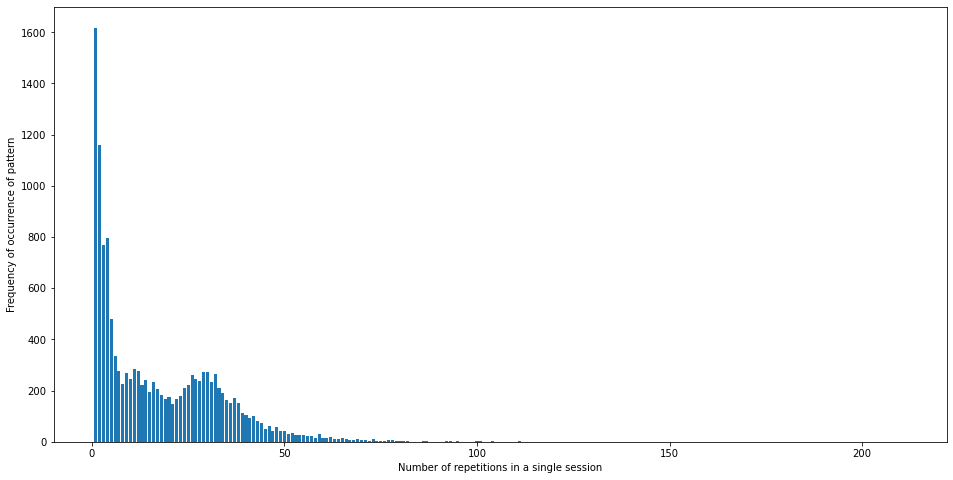

In [8]:
def make_plot(URL_name):
    data = Counter(repetition_df[repetition_df["URL_FILE"] == URL_name]["Rep_count"].values)

    df_aanvragen_ww_rep_counts = pd.DataFrame([data]).T
    df_aanvragen_ww_rep_counts.rename(columns={0: "count"}, inplace=True)

    x = df_aanvragen_ww_rep_counts.index
    y = df_aanvragen_ww_rep_counts["count"].values

    plt.figure(figsize=(16, 8))
    plt.bar(x, y)
    plt.ylabel('Frequency of occurrence of pattern')
    plt.xlabel('Number of repetitions in a single session')
    plt.savefig('repetition_figures/rep_dist_aanvragen_ww.png');

make_plot("/portal/page/portal/home/diensten/aanvragen-ww")
#make_plot("/werk_nl/werknemer/eintake/inschrijven")
#make_plot("/werk_nl/werknemer/mijn_werkmap/werk-zoeken/mijn_cv")
#make_plot("/werk_nl/werknemer/mijn_werkmap/werk-zoeken/vacatures_zoeken")

In [9]:
17.339856 + (2 * 16.467120)

50.274096

In [10]:
repetition_df

,SessionID,URL_FILE,Rep_count
0,46,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,2
1,358,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,3
2,420,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,5
3,447,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,3
4,681,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,2
...,...,...,...
954324,55314390,/werk_nl/werknemer/mijn_werkmap/doorgeven/take...,9
954325,55314390,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,1
954326,55314390,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,3
954327,55314605,/werk_nl/werknemer/mijn_werkmap/werk-zoeken/va...,1


In [11]:
anomaly_sessions = repetition_df[(repetition_df["URL_FILE"] == "/portal/page/portal/home/diensten/aanvragen-ww") & (repetition_df["Rep_count"] > 50)]["SessionID"]

In [12]:
anomaly_sessions.shape

(465,)

In [13]:
anomaly_or_normal = []
for session in df["SessionID"]:
    if session in list(anomaly_sessions):
        anomaly_or_normal.append("potential_anomaly")
    else:
        anomaly_or_normal.append("normal")

In [14]:
df["Label"] = anomaly_or_normal
df[df["Label"] == "potential_anomaly"]
df.to_csv("uwv_data_with_labels.csv")